# MARVEL applied on magnitude MRF signals to obtain multiple quantitative maps

## Load the packages

In [ ]:
import numpy as np
import os
import json
from time import time
import sys

sys.path.append(os.path.join(os.getcwd(), os.pardir))

from Tools.load_save_utils import load_acquisition_reconstruction_from_nii, load_model_weights, _get_brain_acquisition_limits
from Tools.reconstruction_utils import NN_prediction
from Plot.plot_utils import plot_parameter_maps
from Neural_Networks.networks import initialize_network

2025-06-09 19:30:44.390515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-09 19:30:44.410556: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-09 19:30:44.416724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-09 19:30:44.432660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-09 19:30:45.496433: W tensorflow/compiler/tf2

## Load acquisition and ROI

In [ ]:
path_to_summer_current = "/data_network/summer_projects/cungel/Current"

In [ ]:
SENSE_reco_filepath= os.path.join(path_to_summer_current,"2023_MRF_Collab/Lila/tests_cg_sense/reco_acquisitions/reco_cg_sense/fixed_spirals/reco_cg_sense_alpha1_13shots.npy")
RECO_SENSE = np.load(SENSE_reco_filepath)

In [ ]:
roi_filepath = "2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240424/ROI_data/MAPIRMAGE-D00-ROI-brain2D_20240426-085037219"

ROI_brain_map_filepath = os.path.join(path_to_summer_current, roi_filepath)

ROI_brain_map = load_acquisition_reconstruction_from_nii(ROI_brain_map_filepath, nb_indents=1, v=False)[0].astype(np.bool_)
ROI_brain_map = np.rot90(ROI_brain_map)

if ROI_brain_map.ndim == 2:
    ROI_brain_map = ROI_brain_map[:, :, None]

## Predict parameter maps 

### Load the JSON file that contains the network parameters used for training. An example configuration file is provided in this section.

In [ ]:
training_path = os.path.join(path_to_summer_current, '2023_MRF_Collab/Lila/MARVEL_training/DICO8/train_updated_code_v2_LR0.9')

RECOS_INFOS = json.load(open(os.path.join(training_path, 'training_infos.json')))

In [ ]:
#PARAMETERS TO SET
n_epochs = 87
n_pulses = 260

#PARAMETERS SET FROM RECOS_INFOS
NETWORK_INFOS = RECOS_INFOS["NETWORK_INFOS"]
learned_labels = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']
n_parameters = len(learned_labels)
layer_B1_constraint_incorporation = NETWORK_INFOS.get("incorporate_B1_constraint", False)
network_name = NETWORK_INFOS["network_name"]
input_size = n_pulses 
layer_shapes = [input_size] + NETWORK_INFOS["hidden_layer_shapes"] + [n_parameters]
activations = NETWORK_INFOS["activations"]

NN = initialize_network(network_name, layer_shapes, activations, layer_B1_constraint_incorporation)

load_model_weights(NN, layer_shapes, adding_text='_{}epochs'.format(n_epochs), path_to_model=os.path.join(training_path, 'weights'))


INITIALIZE NETWORK
260


/home/cungel/data_ssd/venv/venv_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 260, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100)            │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 75)             │         7,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         3,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,481 (126.88 KB)

 Trainable params: 32,481 (126.88 KB)

 Non-trainable params: 0 (0.00 B)

### Preprocess the input data: 
###  - Reshape to (x, y, z, n_pulses)
###  - Keep only the magnitude
###  - Normalize

In [ ]:
RECO = np.rot90(np.moveaxis(RECO_SENSE, 0, -1), 3)[:, :, None, :n_pulses]
RECO = np.nan_to_num(RECO, nan=0.0, posinf=0.0, neginf=0.0)

RECO = np.abs(RECO)

norm_RECO = np.linalg.norm(RECO, axis=3, keepdims=True)
norm_RECO_safe = np.maximum(norm_RECO, 1e-8)

RECO_normalized = RECO / norm_RECO_safe

### Predict and plot the quantitative maps

Loaded a 192x192 reconstruction with 1 slice and 260 pulses. 


/data_local/data_hdd/cungel/tmp/ipykernel_876326/852736116.py:8: RuntimeWarning: invalid value encountered in divide
  RECO_mask_normalized = RECO / np.linalg.norm(RECO, axis=3)[:, :, :, None]


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/home/cungel/data_ssd/venv/venv_gpu/lib/python3.12/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in clip_fn (vectorized)
  outputs = ufunc(*inputs)
/home/cungel/data_ssd/venv/venv_gpu/lib/python3.12/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in clip_fn (vectorized)
  outputs = ufunc(*inputs)


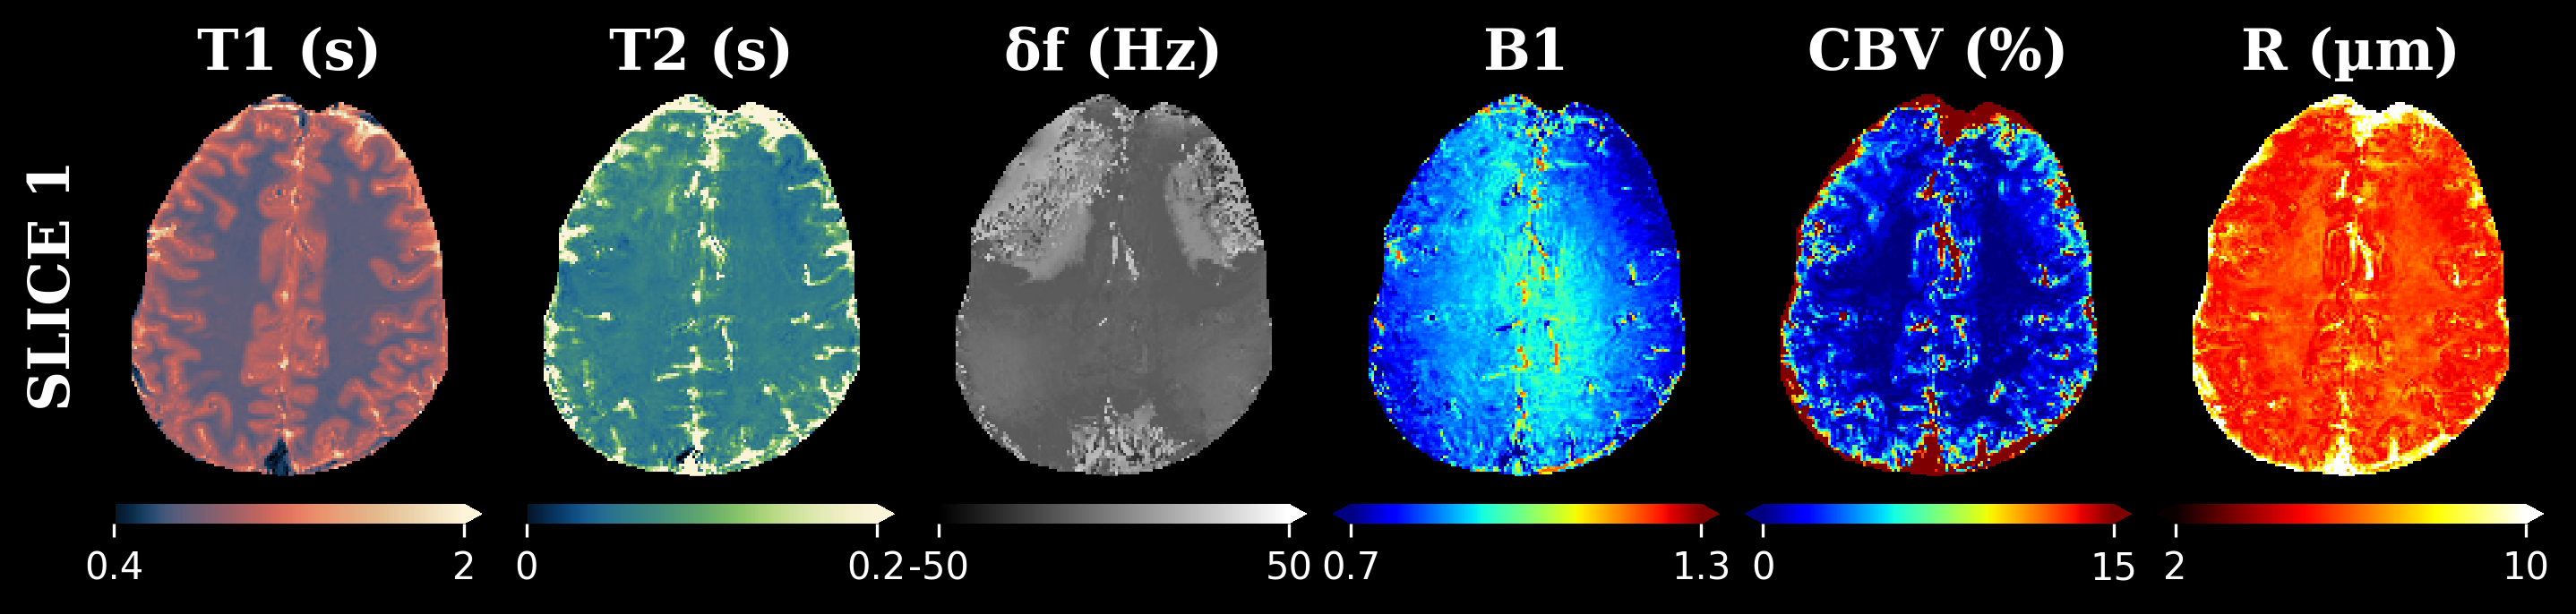

In [ ]:
NN_reconstruction = NN_prediction(NN, RECO_normalized, learned_labels, ROI_brain_map, batch_size=1024)

fig = plot_parameter_maps(NN_reconstruction, learned_labels, crop_type='separate', title='')
